#import all necessary libraries for the machine learning project.

In [1]:
!pip install keras-tuner --upgrade

# import the necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tqdm
from sklearn import metrics, model_selection
# The libraries below are built-into python and are used to work with local storage and directories
import os
import glob
# import the keras auto tuner 
import keras_tuner as kt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.7 MB/s eta 0:00:00


# Download the dataset using tf.keras.dataset

In [2]:
# download the required dataset
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
y_train=y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Create Data Pipeline

In [4]:
# read the image
def get_image_tensor_from_path(image, label):
    image = tf.reshape(image,(28,28,1))
    image = tf.keras.layers.concatenate([image,image,image])
    
    image=tf.image.convert_image_dtype(image,tf.float32)
    

    label=tf.one_hot(label,depth=10) # create the onehot vecotr for the labels 

    return image, label

In [5]:
# test the read the image 
x,y=get_image_tensor_from_path(x_train[0],0)

tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


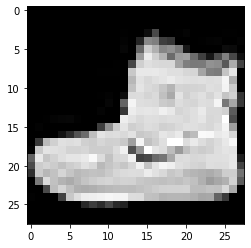

In [6]:
# plot image samples from the dataset
plt.imshow(x)
print(y)

In [7]:
# This is the same function that was defined in the CIFAR10 example
def augment_image(image, label):

    image = tf.image.random_flip_left_right(image)  # Randomly flip an image horizontally
    image = tf.image.random_flip_up_down(image)  # Randomly flips an image vertically
    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)  # Adjust the brightness of images by a random factor
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)  # Adjust the saturation of RGB images by a random factor
    image = tf.clip_by_value(image,0.0,1.0)
    

    

    return image, label


In [8]:
# create the data pipeline
def create_data_pipeline(x, y, batch_size=32, training=False):
    data = tf.data.Dataset.from_tensor_slices((x, y))
    data = data.shuffle(50000)  # Shuffle the data, `2000` represnts the buffer size, read the documentation for more details


    # Convert image paths to image tensors using get_image_tensor_from_path
    data = data.map(get_image_tensor_from_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if (training):  # If training == True then apply train preprocess on dataset, this makes sure that the validation dataset isn't augmented
        data = data.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)  # Applying the augment_image function on dataset
    data = data.batch(batch_size)  # Create mini-batches for the specified size
    # This allows later elements to be prepared while the current element is being processed.
    data = data.prefetch(tf.data.experimental.AUTOTUNE)

    return data

In [9]:
# create the train pipleine 
train_dataset = create_data_pipeline(x_train,y_train, training=True)
# create the test pipeline
test_dataset = create_data_pipeline(x_test,y_test)

In [10]:
for x,y in test_dataset.take(2):
    print(y)
    print(x.shape)
    print(np.argmax(y,axis=-1))

tf.Tensor(
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

In [11]:
# create the model class inheritance from the Model class 
tf.keras.backend.clear_session()
tf.random.set_seed(42)
class CNN_MODEL(tf.keras.Model):
    def __init__(self,class_number,filter_tuner,activation_tuner,kernel_regularizer_tuner,dropout_tuner,featuer_vector_tuner):
        super(CNN_MODEL,self).__init__()
        self.dropout_tuner=dropout_tuner
        self.featuer_vector_tuner=featuer_vector_tuner
        activation_tuner=[tf.nn.relu,tf.nn.leaky_relu,tf.nn.elu][activation_tuner]


        self.c1=tf.keras.layers.Conv2D(filter_tuner[0],3,padding='same',activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[0])
        self.c2=tf.keras.layers.Conv2D(filter_tuner[1],3,padding='same',activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[1])
        self.max_1= tf.keras.layers.MaxPooling2D()
        self.c3=tf.keras.layers.Conv2D(filter_tuner[2],3,padding='same',activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[2])
        self.c4=tf.keras.layers.Conv2D(filter_tuner[3],3,padding='same',activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[3])
        self.max_2= tf.keras.layers.MaxPooling2D()
        self.c5=tf.keras.layers.Conv2D(filter_tuner[4],3,padding='same',activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[4])

        
        self.D1=tf.keras.layers.Dense(filter_tuner[5],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[5])
        self.D2=tf.keras.layers.Dense(filter_tuner[6],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[6])
        
        self.out=tf.keras.layers.Dense(class_number)

        if dropout_tuner ==True:
            self.D1_dropout=tf.keras.layers.Dropout(0.4)
            self.D2_dropout=tf.keras.layers.Dropout(0.4)
    def call(self,x):
        x=self.c1(x)
        x=self.c2(x)
        x=self.max_1(x)
        x=self.c3(x)
        x=self.c4(x)
        x=self.max_2(x)
        x=self.c5(x)
        if self.featuer_vector_tuner=='Flatten':
            x=tf.reshape(x,(-1,7*7*256))
        else :
            x= tf.keras.layers.GlobalAvgPool2D()(x)
        
        x=self.D1(x)
        if self.dropout_tuner:
            x=self.D1_dropout(x)
        x=self.D2(x)
        if self.dropout_tuner:
            x=self.D2_dropout(x)
     
        x=self.out(x)
        x=tf.nn.softmax(x)
        return x 


In [16]:
def model_builder(hp):
    # define the kernel values tuner 
    filter_tuner=[hp.Int('f_conv_1', min_value=8, max_value=512, step=32),
                  hp.Int('f_conv_2', min_value=8, max_value=512, step=32),
                  hp.Int('f_conv_3', min_value=8, max_value=512, step=32),
                  hp.Int('f_conv_4', min_value=8, max_value=512, step=32),
                  hp.Int('f_conv_5', min_value=8, max_value=512, step=32),
                  hp.Int('f_conv_6', min_value=8, max_value=512, step=32),
                  hp.Int('f_conv_7', min_value=8, max_value=512, step=32)]
    # define the activation function tuner 
    activation_tuner = hp.Choice('activation',[0,1,2])

    # define the kernel_regularizer_tuner
    kernel_regularizer_tuner=[hp.Choice('regularizer_1',['L1','L2','L1L2']),
                              hp.Choice('regularizer_2',['L1','L2','L1L2']),
                              hp.Choice('regularizer_3',['L1','L2','L1L2']),
                              hp.Choice('regularizer_4',['L1','L2','L1L2']),
                              hp.Choice('regularizer_5',['L1','L2','L1L2']),
                              hp.Choice('regularizer_6',['L1','L2','L1L2']),
                              hp.Choice('regularizer_7',['L1','L2','L1L2']),]
    # define the dropout_tuner
    dropout_tuner= hp.Choice('dropout',[True,False])
    # define the featuer_vector_tuner
    featuer_vector_tuner= hp.Choice('dropout',['Flatten','GlobalAvgPool2D'])
    
    model = CNN_MODEL(class_number=10,
                      filter_tuner=filter_tuner,
                      activation_tuner=activation_tuner,
                      kernel_regularizer_tuner=kernel_regularizer_tuner,
                      dropout_tuner=dropout_tuner,
                      featuer_vector_tuner=featuer_vector_tuner
                      )
    
    model.build((None,28,28,3))# build the model 
    
    # define the learning rate tuner 
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # compile the model 
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"]
    )
    return model 

In [17]:

tuner = kt.BayesianOptimization(model_builder,
                     objective='val_accuracy',
                     max_trials=10,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [18]:


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [19]:
tuner.search(train_dataset, epochs=50,validation_data=test_dataset , callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 10 Complete [00h 04m 54s]
val_accuracy: 0.10000000149011612

Best val_accuracy So Far: 0.8664000034332275
Total elapsed time: 01h 04m 52s


In [20]:
a=tuner.get_best_hyperparameters()[0]
a.values

{'f_conv_1': 392,
 'f_conv_2': 40,
 'f_conv_3': 328,
 'f_conv_4': 40,
 'f_conv_5': 136,
 'f_conv_6': 200,
 'f_conv_7': 328,
 'activation': 0,
 'regularizer_1': 'L1L2',
 'regularizer_2': 'L1L2',
 'regularizer_3': 'L1L2',
 'regularizer_4': 'L2',
 'regularizer_5': 'L2',
 'regularizer_6': 'L2',
 'regularizer_7': 'L2',
 'dropout': 0,
 'lr': 0.00035978875710346195}

## Model Evaluation 

In [21]:
model = model_builder(tuner.get_best_hyperparameters()[0])

In [22]:
model.summary()

Model: "cnn_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           multiple                  10976     
                                                                 
 conv2d_6 (Conv2D)           multiple                  141160    
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           multiple                  118408    
                                                                 
 conv2d_8 (Conv2D)           multiple                  118120    
                                                                 
 max_pooling2d_3 (MaxPooling  multiple                 0         
 2D)                                                   

In [23]:
model.fit(train_dataset,epochs=50,validation_data=test_dataset)

Epoch 1/50
1875/1875 [==============================] - 33s 16ms/step - loss: 1.6916 - accuracy: 0.6234 - val_loss: 1.0352 - val_accuracy: 0.7122
Epoch 2/50
1875/1875 [==============================] - 30s 16ms/step - loss: 0.9170 - accuracy: 0.7327 - val_loss: 0.8415 - val_accuracy: 0.7431
Epoch 3/50
1875/1875 [==============================] - 30s 16ms/step - loss: 0.7820 - accuracy: 0.7578 - val_loss: 0.6846 - val_accuracy: 0.7948
Epoch 4/50
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7082 - accuracy: 0.7824 - val_loss: 0.7053 - val_accuracy: 0.7885
Epoch 5/50
1875/1875 [==============================] - 30s 16ms/step - loss: 0.6505 - accuracy: 0.8042 - val_loss: 0.6319 - val_accuracy: 0.8133
Epoch 6/50
1875/1875 [==============================] - 30s 16ms/step - loss: 0.6045 - accuracy: 0.8219 - val_loss: 0.5666 - val_accuracy: 0.8403
Epoch 7/50
1875/1875 [==============================] - 30s 16ms/step - loss: 0.5701 - accuracy: 0.8357 - val_loss: 0.5371 -

<AxesSubplot:>

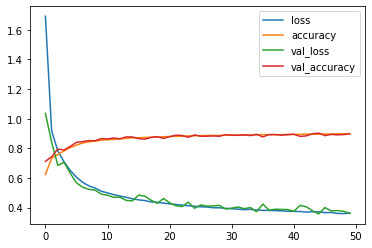

In [24]:
pd.DataFrame(model.history.history).plot()

In [25]:
preds=np.array([])
ys=np.array([])
for x,y in tqdm.tqdm(test_dataset):
    pred = np.argmax( model.predict(x),axis=-1)
    y=np.argmax( y,axis=-1)
    preds=np.append(preds,pred)
    ys=np.append(ys,y)
    
    

  0%|          | 0/313 [00:00<?, ?it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 1/313 [00:00<01:25,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 3/313 [00:00<00:36,  8.58it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 5/313 [00:00<00:28, 10.96it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 7/313 [00:00<00:24, 12.60it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 9/313 [00:00<00:22, 13.52it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 11/313 [00:00<00:21, 13.95it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 13/313 [00:01<00:21, 13.93it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 15/313 [00:01<00:21, 13.72it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 17/313 [00:01<00:21, 14.04it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 19/313 [00:01<00:21, 13.74it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 21/313 [00:01<00:20, 14.26it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 23/313 [00:01<00:19, 14.75it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 25/313 [00:01<00:19, 14.58it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 27/313 [00:02<00:19, 14.97it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 29/313 [00:02<00:18, 14.98it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 31/313 [00:02<00:18, 15.11it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 33/313 [00:02<00:18, 15.38it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 35/313 [00:02<00:18, 14.85it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 37/313 [00:02<00:18, 15.26it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 39/313 [00:02<00:17, 15.64it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 41/313 [00:02<00:17, 15.89it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 43/313 [00:03<00:16, 16.14it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 45/313 [00:03<00:16, 15.88it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 47/313 [00:03<00:16, 16.09it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 49/313 [00:03<00:16, 16.10it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 51/313 [00:03<00:16, 15.65it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 53/313 [00:03<00:16, 15.67it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 55/313 [00:03<00:16, 15.92it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 57/313 [00:03<00:16, 15.70it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 59/313 [00:04<00:15, 16.12it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 61/313 [00:04<00:15, 16.35it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 63/313 [00:04<00:15, 16.17it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 65/313 [00:04<00:15, 15.68it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 67/313 [00:04<00:15, 15.77it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 69/313 [00:04<00:15, 16.10it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 71/313 [00:04<00:14, 16.29it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 73/313 [00:04<00:14, 16.05it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 75/313 [00:05<00:14, 16.24it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 77/313 [00:05<00:14, 16.61it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 79/313 [00:05<00:14, 16.42it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 81/313 [00:05<00:14, 16.19it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 83/313 [00:05<00:14, 15.65it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 85/313 [00:05<00:14, 15.63it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 87/313 [00:05<00:16, 13.79it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 89/313 [00:06<00:17, 12.69it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 91/313 [00:06<00:18, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 93/313 [00:06<00:18, 11.68it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 95/313 [00:06<00:19, 11.15it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 97/313 [00:06<00:19, 11.05it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 99/313 [00:06<00:19, 11.01it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 101/313 [00:07<00:19, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 103/313 [00:07<00:19, 10.93it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 105/313 [00:07<00:18, 11.02it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 107/313 [00:07<00:18, 11.04it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 109/313 [00:07<00:18, 11.07it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 111/313 [00:08<00:17, 11.82it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 113/313 [00:08<00:15, 12.76it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 115/313 [00:08<00:14, 13.81it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 117/313 [00:08<00:13, 14.66it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 119/313 [00:08<00:13, 14.90it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 121/313 [00:08<00:12, 15.07it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 123/313 [00:08<00:12, 15.20it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 125/313 [00:08<00:12, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 127/313 [00:09<00:11, 15.82it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 129/313 [00:09<00:11, 16.20it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 131/313 [00:09<00:11, 15.98it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 133/313 [00:09<00:11, 15.84it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 135/313 [00:09<00:11, 16.16it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 137/313 [00:09<00:10, 16.00it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 139/313 [00:09<00:11, 15.77it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 141/313 [00:09<00:10, 15.83it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 143/313 [00:10<00:10, 16.25it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 145/313 [00:10<00:10, 16.44it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 147/313 [00:10<00:09, 16.65it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 149/313 [00:10<00:10, 16.29it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 151/313 [00:10<00:10, 16.11it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 153/313 [00:10<00:10, 15.93it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 155/313 [00:10<00:09, 15.93it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 157/313 [00:10<00:09, 16.30it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 159/313 [00:10<00:09, 16.28it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 161/313 [00:11<00:09, 16.49it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 163/313 [00:11<00:09, 16.29it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 165/313 [00:11<00:09, 16.07it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 167/313 [00:11<00:09, 16.00it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 169/313 [00:11<00:09, 15.49it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 171/313 [00:11<00:09, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 173/313 [00:11<00:08, 15.83it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 175/313 [00:12<00:08, 15.59it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 177/313 [00:12<00:08, 15.51it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 179/313 [00:12<00:08, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 181/313 [00:12<00:08, 16.07it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 183/313 [00:12<00:08, 16.08it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 185/313 [00:12<00:07, 16.11it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 187/313 [00:12<00:08, 15.74it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 189/313 [00:12<00:07, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 191/313 [00:13<00:07, 15.96it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 193/313 [00:13<00:07, 15.89it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 195/313 [00:13<00:07, 16.19it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 197/313 [00:13<00:07, 16.29it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 199/313 [00:13<00:07, 16.19it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 201/313 [00:13<00:07, 15.97it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 203/313 [00:13<00:06, 15.96it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 205/313 [00:13<00:06, 16.35it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 207/313 [00:14<00:06, 16.05it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 209/313 [00:14<00:06, 16.47it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 211/313 [00:14<00:06, 16.32it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 213/313 [00:14<00:06, 16.36it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 215/313 [00:14<00:05, 16.41it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 217/313 [00:14<00:05, 16.12it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 219/313 [00:14<00:05, 15.82it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 221/313 [00:14<00:05, 16.02it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 223/313 [00:14<00:05, 16.44it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 225/313 [00:15<00:05, 16.20it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 227/313 [00:15<00:05, 15.89it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 229/313 [00:15<00:05, 16.03it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 231/313 [00:15<00:04, 16.48it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 233/313 [00:15<00:05, 15.94it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 235/313 [00:15<00:04, 16.05it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 237/313 [00:15<00:04, 15.86it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 239/313 [00:15<00:04, 16.15it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 241/313 [00:16<00:04, 16.16it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 243/313 [00:16<00:04, 16.49it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 245/313 [00:16<00:04, 16.50it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 247/313 [00:16<00:04, 16.26it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 249/313 [00:16<00:03, 16.29it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 251/313 [00:16<00:03, 16.52it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 253/313 [00:16<00:03, 16.12it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 255/313 [00:16<00:03, 16.22it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 257/313 [00:17<00:03, 16.35it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 259/313 [00:17<00:03, 16.57it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 261/313 [00:17<00:03, 16.76it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 263/313 [00:17<00:02, 16.75it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 265/313 [00:17<00:03, 15.79it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 267/313 [00:17<00:02, 16.05it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 269/313 [00:17<00:02, 16.15it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 271/313 [00:17<00:02, 16.51it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 273/313 [00:18<00:02, 14.55it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 275/313 [00:18<00:02, 13.13it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 277/313 [00:18<00:02, 12.39it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 279/313 [00:18<00:02, 11.95it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 281/313 [00:18<00:02, 11.64it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 283/313 [00:19<00:02, 11.28it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 285/313 [00:19<00:02, 11.31it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 287/313 [00:19<00:02, 11.40it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 289/313 [00:19<00:02, 11.31it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 291/313 [00:19<00:01, 11.39it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 293/313 [00:19<00:01, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 295/313 [00:20<00:01, 11.99it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 297/313 [00:20<00:01, 11.86it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 299/313 [00:20<00:01, 12.10it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 301/313 [00:20<00:00, 12.86it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 303/313 [00:20<00:00, 13.71it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 305/313 [00:20<00:00, 14.48it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 307/313 [00:20<00:00, 14.89it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 309/313 [00:21<00:00, 15.23it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 311/313 [00:21<00:00, 15.72it/s]

1/1 [==============================] - 0s 105ms/step


100%|██████████| 313/313 [00:40<00:00,  7.64it/s]


accuracy_score: 0.8977
precision_score: 0.9005164890148987
recall_score: 0.8977
f1_score: 0.8983915780822656


<AxesSubplot:>

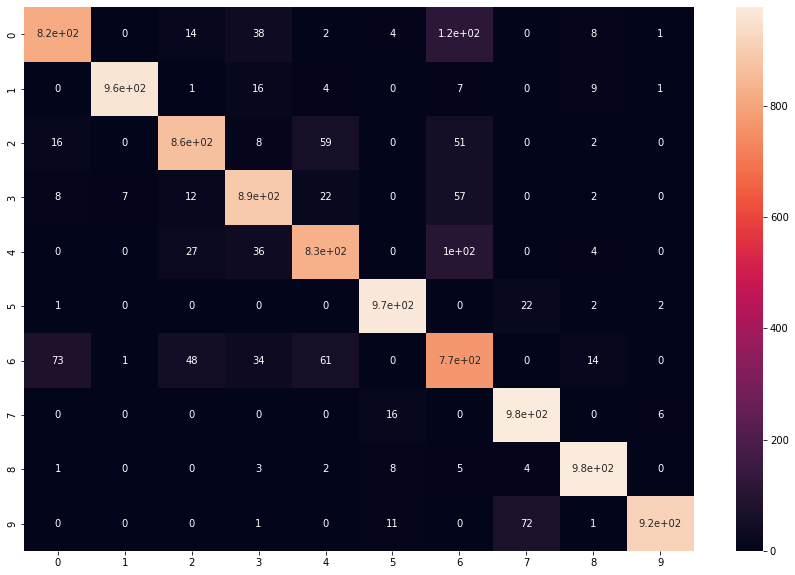

In [26]:
accuracy_score=metrics.accuracy_score(y_true=ys,y_pred=preds)
precision_score=metrics.precision_score(ys,preds,average='weighted')
recall_score=metrics.recall_score(ys,preds,average='weighted')
f1_score=metrics.f1_score(ys,preds,average='weighted')
confion_metrix=metrics.confusion_matrix(ys,preds)
print('accuracy_score:',accuracy_score)
print('precision_score:',precision_score)
print('recall_score:',recall_score)
print('f1_score:',f1_score)
plt.figure(figsize=(15,10))
sn.heatmap(confion_metrix,annot=True,)